# GoHealth Data Science Case Study

In [127]:
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Notebook Last Run Initiated: 2020-12-24 14:02:13.390571


## Standard Python Modules

In [2]:
from numpy import reshape
from pandas import DataFrame, Series, to_datetime
import xgboost
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score    
from sklearn.feature_selection import SelectFromModel
from transform import transformData

import sys
print(sys.version)

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# Model Inputs

In [31]:
from pandas import read_csv
data = read_csv("dataset.csv")
from pandas import to_datetime
data["Membership Start Date"] = to_datetime(data["Membership Start Date"])
data["Transaction Date"] = to_datetime(data["Transaction Date"])
data.shape

(49465, 5)

In [13]:
data.head()

,Customer ID,Membership Start Date,Transaction Date,Payment Type,Revenue
0,386379,2019-02-19,2019-02-18,Annual Fee,285.9
1,386379,2019-02-19,2019-02-18,Monthly Fee,26.5
2,386379,2019-02-19,2019-03-19,Monthly Fee,26.5
3,386379,2019-02-19,2019-04-19,Monthly Fee,26.5
4,386379,2019-02-19,2019-05-19,Monthly Fee,26.5


# Question 1

In [36]:
# Which month had the highest revenue (by "Transaction Date")?

In [33]:
data["Transaction Month"] = data["Transaction Date"].dt.strftime("%B")

0        February
1        February
2           March
3           April
4             May
           ...   
49460       April
49461       April
49462       April
49463       April
49464         May
Name: Transaction Month, Length: 49465, dtype: object

In [34]:
## This code computes the sum of revenue grouped by transaction month
revenue_by_month = data.groupby("Transaction Month").agg({'Revenue': 'sum'})
revenue_by_month

,Revenue
Transaction Month,
April,741514.300
August,709209.205
December,1255965.000
February,946181.200
January,919455.300
July,545955.485
June,106774.470
March,942902.100
May,127041.910


In [35]:
# Month with highest revenue
revenue_by_month["Revenue"].idxmax()

'December'

In [37]:
# What was the percentage of revenue for that month by payment type?

In [49]:
decemberData = data[data["Transaction Month"] == "December"]
decemberData.groupby(["Payment Type"]).agg({"Revenue": "sum"}).apply(lambda x: x / x.sum())

,Revenue
Payment Type,
Annual Fee,0.915729
Monthly Fee,0.084271


# Question 2

In [50]:
data.head()

,Customer ID,Membership Start Date,Transaction Date,Payment Type,Revenue,Transaction Month
0,386379,2019-02-19,2019-02-18,Annual Fee,285.9,February
1,386379,2019-02-19,2019-02-18,Monthly Fee,26.5,February
2,386379,2019-02-19,2019-03-19,Monthly Fee,26.5,March
3,386379,2019-02-19,2019-04-19,Monthly Fee,26.5,April
4,386379,2019-02-19,2019-05-19,Monthly Fee,26.5,May


In [55]:
data["Membership MonthYear"] = data["Membership Start Date"].dt.strftime("%Y-%m")

In [62]:
membershipMonthYear = data.groupby("Customer ID").agg({"Membership MonthYear": "min"})
membershipMonthYear

,Membership MonthYear
Customer ID,
312897,2018-07
313273,2018-07
313571,2018-07
314200,2018-07
314478,2018-07
...,...
404346,2019-04
404388,2019-04
404410,2019-04


In [68]:
customers_by_monthyear = data.groupby("Membership MonthYear").agg({"Customer ID": "nunique"})
customers_by_monthyear

,Customer ID
Membership MonthYear,
2018-07,720
2018-08,883
2018-09,916
2018-10,933
2018-11,1278
2018-12,1254
2019-01,1604
2019-02,1314
2019-03,1229


In [70]:
customers_by_monthyear[customers_by_monthyear.index == "2018-12"]

,Customer ID
Membership MonthYear,
2018-12,1254


# Question 3

In [73]:
membersInJuly2018 = data[data["Membership MonthYear"] == "2018-07"]
membersInJuly2018.head()

,Customer ID,Membership Start Date,Transaction Date,Payment Type,Revenue,Transaction Month,Membership MonthYear
85,321309,2018-07-05,2018-07-04,Annual Fee,331.905,July,2018-07
86,321309,2018-07-05,2018-07-04,Monthly Fee,26.500,July,2018-07
87,321309,2018-07-05,2018-08-05,Monthly Fee,26.500,August,2018-07
88,321309,2018-07-05,2018-10-03,Monthly Fee,26.500,October,2018-07
89,321309,2018-07-05,2018-10-05,Monthly Fee,26.500,October,2018-07


In [81]:
def getMonths(x):
    return x[x["Payment Type"] == "Monthly Fee"].shape[0]
numberOfMonths = membersInJuly2018.groupby("Customer ID").apply(getMonths)

In [88]:
print("Continued Paying for {0} Months".format(round(numberOfMonths.mean(),2)))

Continued Paying for 4.92 Months


# Question 4

I would build a CLV (customer lifetime value) model to compute the conditional probabilities that a customer will purchase X amount of product over some Y amount of time. I am using the 'lifetimes' Python library to compute compute this model.

# Question 5

In [ ]:
monthlyData = data[data["Payment Type"] == "Monthly Fee"].copy()
monthlyData["Transaction Month"] = monthlyData["Transaction Date"].dt.strftime("%Y-%m")

In [102]:
users = []
for cID,df in monthlyData.groupby("Customer ID"):
    if "2019-05" in df["Transaction Month"].values:
        users.append(cID)
print("There are {0} active customers that paid a monthly fee in May 2019".format(len(users)))

There are 4533 customers that paid a monthly fee in May 2019


In [90]:
mayMonthlyData = monthlyData[monthlyData["Customer ID"].isin(users)].copy(deep=True)

In [106]:
# Compute when the probability falls below 50% for each customer

In [117]:
lastDate = {}
for cID,df in mayMonthlyData.groupby("Customer ID"):
    sdf = calculate_alive_path(bgf, df, "Transaction Date", 1000)
    for day,value in sdf.iteritems():        
        if value < 0.5:
            lastDate[cID] = [day,df["Transaction Date"].max()]                
            #print(cID,lastDate[cID])
            break
    if len(lastDate) % 100 == 0:
        print(len(lastDate))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500


In [118]:
lastTime = {}
for cID,cIDData in lastDate.items():
    lastTime[cID] = cIDData[1] + timedelta(days=cIDData[0])

In [126]:
from pandas import Series
Series({cID: cTime.strftime("%Y-%m-%d") for cID,cTime in lastTime.items()}).to_csv("end_dates.csv")

In [41]:
monthlyData = data[data["Payment Type"] == "Monthly Fee"].copy()

In [56]:
sdata = summary_data_from_transaction_data(monthlyData, 'Customer ID', 'Transaction Month',
                                           monetary_value_col='Revenue', observation_period_end='2019-05')
sdata

,frequency,recency,T,monetary_value
Customer ID,,,,
312897,0.0,0.0,365.0,0.0
313273,3.0,122.0,334.0,26.5
313571,3.0,122.0,334.0,26.5
314200,0.0,0.0,334.0,0.0
314478,1.0,61.0,334.0,26.5
...,...,...,...,...
404346,0.0,0.0,30.0,0.0
404388,1.0,30.0,30.0,26.5
404410,1.0,30.0,30.0,26.5


In [67]:
bgf = BetaGeoFitter(penalizer_coef=0.00001)
bgf.fit(sdata['frequency'], sdata['recency'], sdata['T'])

<lifetimes.BetaGeoFitter: fitted with 11194 subjects, a: 0.08, alpha: 88.77, b: 2.48, r: 1.45>

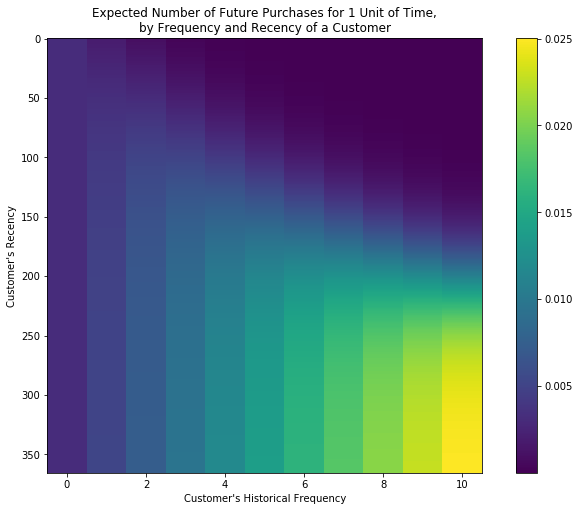

In [68]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

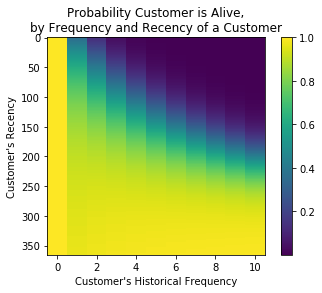

In [69]:
plot_probability_alive_matrix(bgf)

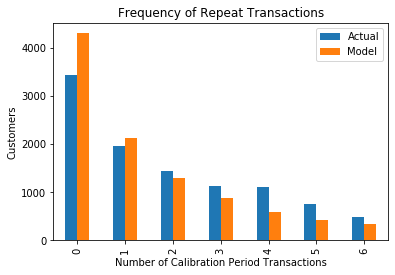

In [60]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)